In [1]:
from typing import Iterator
from torch.nn.parameter import Parameter
import torch.nn as nn
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from algorithm.fedprob_utils.smooth import Smooth
import utils.fflow as flw
import torch
import multiprocessing
import pickle
import matplotlib.pyplot as plt
import ujson
import random


# Settings
fedtask = "cifar100_cnum50_distcluster_skew0.5_seed0"
record_path = '/mnt/disk1/naver/hieunguyen/provably_fl/fedtask/cifar100_cnum50_distcluster_skew0.5_seed0/record/fedprob_N_0.25Mresnet18_R300_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json'
algorithm = "fedprob"
model = "resnet18"
sigma = 0.25
num_epochs = 5
lr = 0.05
gpu_id = -1
option = {
    "task": fedtask,
    "algorithm": algorithm,
    "model": model,
    "sample": "uniform",
    "aggregate": "none",
    "learning_rate_decay": 0.998,
    "weight_decay": 0,
    "lr_scheduler": -1,
    "sigma": sigma,
    "num_rounds": 20,
    "proportion": 0.2,
    "num_epochs": num_epochs,
    "learning_rate": lr,
    "batch_size": 64,
    "optimizer": "SGD",
    "momentum": 0,
    "seed": 0,
    "eval_interval": 1,
    "num_threads": 1,
    "num_threads_per_gpu": 1,
    "num_gpus": 3,
    "gpu": 0,
    "net_drop": 0,
    "net_active": 99999,
    "capability": 0,
    "learning_rate_lambda": 0,
    "q": 0.0,
    "epsilon": 0.0,
    "eta": 1.0,
    "tau": 0,
    "alpha": 0.0,
    "beta": 1.0,
    "gamma": 0.0,
    "mu": 0.1,
    "server_gpu_id": gpu_id,
}

# load server
# read options
os.environ['MASTER_ADDR'] = "localhost"
os.environ['MASTER_PORT'] = '8888'
os.environ['WORLD_SIZE'] = str(3)
# set random seed
flw.setup_seed(option['seed'])
# initialize server
server = flw.initialize(option)


init fedtask...done
init clients...done
init server...done


In [6]:
server_labels = []
client_labels = {}
num_client = 0
client_class_num = np.zeros((100,))
cnum_client = []

for X, Y in server.test_data:
    server_labels.append(Y)
for client in server.clients:
    client_labels[client.name] = []
    for X, Y in client.valid_data:
        client_labels[client.name].append(Y.item())
    num_client += len(client_labels[client.name])
    class_num, bins = np.histogram(client_labels[client.name], range=[0, 100])
    cnum_client.append(class_num)
    client_class_num += class_num

num_server = len(server_labels)

server_class_num, bins = np.histogram(server_labels)

ValueError: operands could not be broadcast together with shapes (100,) (10,) (100,) 

In [7]:
client_class_num.shape , class_num.shape

((100,), (10,))

In [2]:
import json
record_data = json.load(open(record_path, "r"))
record_data['client_certify_acc'].keys()
per_client_accuracy = [np.array(record_data['client_certify_acc'][client_name]) for client_name in record_data['client_certify_acc'].keys()]
per_client_accuracy = np.array(per_client_accuracy).T

In [3]:
# A.shape : k * n 
A = np.array(cnum_client)
client_vols = A.sum(axis=1)
client_sort = (-client_vols).argsort()

In [4]:
A.shape

(50, 10)

In [28]:
import copy
num_random = 1000
# pp_solutions = [[] for i in range(16)]
pp_solutions = []
sample_client_sort = (-A.sum(axis=1)).argsort()
num_sample_client = A.sum(axis=1)
choice_clients = np.where(num_sample_client >= 20)[0].tolist()
print(len(choice_clients))

for i in tqdm(range(num_random)):
    selected_client = []
    clients = choice_clients.copy()
    for j in range(10):
        selected_client.append(random.choice(clients))
        clients.remove(selected_client[-1])
    A_matrix = A[selected_client]
    A_matrix = A_matrix / (np.expand_dims(A_matrix.sum(axis=1), axis=-1))
    C = per_client_accuracy[:, selected_client]
    C = torch.Tensor(C)
    try:
        x = torch.linalg.solve(torch.Tensor(A_matrix).T, torch.ones((10, 1)) * 0.1)
        if torch.any(x < 0) | torch.any(x > 1):
            continue
        solution = C @ x
        pp_solutions.append(solution)
    except torch.linalg.LinAlgError:
        continue

32


100%|██████████| 1000/1000 [00:03<00:00, 322.38it/s]


In [29]:
server_cert_result = np.array(record_data['server_certify_acc'])
client_vols = np.array(cnum_client).sum(axis=1) / np.array(cnum_client).sum()
client_vols = np.expand_dims(client_vols, axis=-1)
client_cert_result = per_client_accuracy @ client_vols

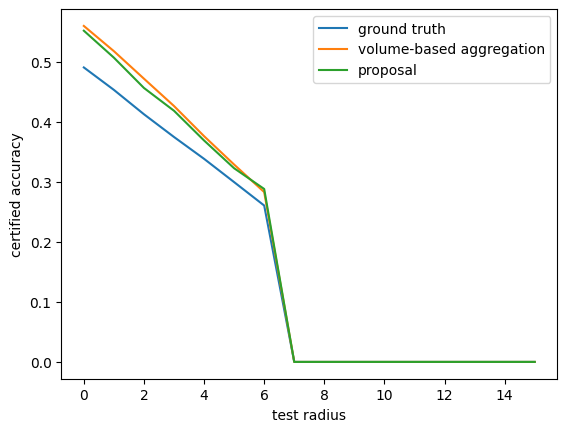

In [30]:
final_solution = 0
for solution in pp_solutions:
    final_solution = final_solution + solution
final_solution = final_solution / len(pp_solutions)
plt.clf()
plt.plot(server_cert_result, label="ground truth")
plt.plot(client_cert_result, label="volume-based aggregation")
plt.plot(final_solution, label="proposal")
plt.xlabel("test radius")
plt.ylabel("certified accuracy")

# for solution in pp_solutions:
#     plt.plot(solution)
plt.legend()

In [1]:
import torch
L = torch.ones(1) * 0.1 
L

tensor([0.1000])

In [4]:
L.requires_grad

False